### Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

D:\python\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

In [15]:
final['Score'].value_counts()

1    293516
0     54744
Name: Score, dtype: int64

In [16]:
pos_reviews=final[final['Score']== 1].sample(n=50000)
neg_reviews=final[final['Score']== 0].sample(n=50000)
a=(pos_reviews,neg_reviews)
final=pd.concat(a)

# FEATURE ENGINEERING

In [17]:
#Concating both the summary and text inorder to improve the model and then using it to test the model

#https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python

final['TEXT_SUMMARY']=final['Text'] +" "+ final["Summary"]

final=final.sort_values(by='Time')



final['TEXT_SUMMARY'][:1]==(final['Text'][:1]+" "+final['Summary'][:1])


417838    True
dtype: bool

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# printing some random reviews
sent_0 =final['TEXT_SUMMARY'].values[0]


sent_1000 =final['TEXT_SUMMARY'].values[1000]


sent_1500 =final['TEXT_SUMMARY'].values[1500]


sent_4900 =final['TEXT_SUMMARY'].values[4900]


# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_1500 = decontracted(sent_1500)


#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()


#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice! FANTASTIC!


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:02<00:00, 1595.09it/s]


In [19]:
preprocessed_reviews[1500]

'good product nice alternative cheese puffs brands not healthy make good occasional treat'

In [20]:
import pickle
with open("final['Score'].pkl",'wb') as f:
    pickle.dump(final['Score'],f)

with open("preprocessed_reviews.pkl",'wb') as f:
    pickle.dump(preprocessed_reviews,f)


In [3]:
import pickle
with open("final['Score'].pkl",'rb') as f :
    final_Score =pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    preprocessed_reviews=pickle.load(f)

# [4] Featurization

In [4]:
len(preprocessed_reviews)

100000

In [23]:
len(final_Score)

100000

In [6]:
# SPLITTING THE DATA INTO TEST TRAIN AND CV


x_train= preprocessed_reviews[:5000]


## [4.1] BAG OF WORDS

In [22]:
print("VECTOR OF THE TEXT AND SUMMARY")
print("-------------------------------------------")
#train_BoW

count_vect = CountVectorizer() #in scikit-learn
train_bow  = count_vect.fit_transform(x_train )
print("the type of count vectorizer ",type(train_bow ))
print("the shape of out text BOW vectorizer ",train_bow .get_shape())
print("the number of unique words ", train_bow .get_shape()[1])
print("********************************************")


VECTOR OF THE TEXT AND SUMMARY
-------------------------------------------
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 43974)
the number of unique words  43974
********************************************




## [4.2] Bi-Grams and n-Grams.

In [6]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [7]:
print("VECTOR OF TEXT AND SUMMARY")
print("                                  ")
#tfidf_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
train_tf_idf = tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])


VECTOR OF TEXT AND SUMMARY
                                  
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 973303)
the number of unique words including both unigrams and bigrams  973303


## [4.3] AVG Word2Vec

In [8]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))



number of words that occured minimum 5 times  4133
sample words  ['beetlejuice', 'excellent', 'funny', 'movie', 'keaton', 'hilarious', 'great', 'special', 'effects', 'help', 'film', 'think', 'one', 'best', 'movies', 'ever', 'made', 'sure', 'agree', 'good', 'time', 'watch', 'always', 'enjoyed', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'something', 'strong', 'usually', 'version', 'warned', 'want', 'avoid', 'bought', 'apartment', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically']


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3086.29it/s]


5000
50


## TFIDF-W2V

In [9]:
## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1





number of words that occured minimum 5 times  4133
sample words  ['beetlejuice', 'excellent', 'funny', 'movie', 'keaton', 'hilarious', 'great', 'special', 'effects', 'help', 'film', 'think', 'one', 'best', 'movies', 'ever', 'made', 'sure', 'agree', 'good', 'time', 'watch', 'always', 'enjoyed', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'something', 'strong', 'usually', 'version', 'warned', 'want', 'avoid', 'bought', 'apartment', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically']


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.79it/s]


# [5] Assignment 9: Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [7]:
from sklearn.cluster import KMeans 
def kMeans(x_train):
    clus=range(1,19,2)
    list_inertia=[]
    for i in  clus:
        a=[]
        clf=KMeans(n_clusters=i,   n_jobs=-1, algorithm="auto",precompute_distances="auto")
        clf.fit(x_train)
        a=clf.inertia_
        list_inertia.append(a)
        print("For no of cluster ",i, " the inertia is ",a)
    print(list_inertia)
    return list_inertia,clf

In [8]:
def inertia_curve(list):
    y=range(1,19,2)
    plt.plot(y,list,'r',marker="o")
    plt.title('inertia verses the k-cluster')
    plt.ylabel('inertia')
    plt.xlabel('k-cluster')
    
#     plt.show()


In [9]:
def wordcloud_of_cluster(vect,k,X):
    clf=KMeans(n_clusters=k).fit(X)
    values=clf.cluster_centers_.argsort()[:,::-1]
    feature_names=vect.get_feature_names()
    return k,values,feature_names,clf

In [18]:
from wordcloud import WordCloud

def wordcloud(i,k,values,feature_names):
        list=[]
        print("CLUSTER ====>>> ",i+1)
        print("----------------------")
        for index in values[i,:40]:
            list.append(feature_names[index])
        print(list)
        wordcloud=WordCloud(background_color="white").generate(str(list))
        plt.figure(figsize=(6,6))
        plt.imshow(wordcloud,interpolation='bilinear')
        plt.axis("off")
        print(plt.show)
        print("******************************")
        
        

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [4]:
# Please write all the code with proper documentation
list_kmeans_bow,clf=kMeans(x_train=train_bow)


For no of cluster  1  the inertia is  3027176.7984600323
For no of cluster  2  the inertia is  2929561.550390014
For no of cluster  3  the inertia is  2891297.5459438968
For no of cluster  4  the inertia is  2860474.393414304
For no of cluster  5  the inertia is  2832678.418255732
For no of cluster  6  the inertia is  2817860.1763225305
For no of cluster  7  the inertia is  2805268.3397127143
For no of cluster  8  the inertia is  2794787.7650359673
For no of cluster  9  the inertia is  2784086.637343029
For no of cluster  10  the inertia is  2773648.316072515
For no of cluster  11  the inertia is  2766242.826433002
For no of cluster  12  the inertia is  2758313.492142819
For no of cluster  13  the inertia is  2755222.0612812084
For no of cluster  14  the inertia is  2744354.64592606
For no of cluster  15  the inertia is  2731422.439127512
For no of cluster  12  the inertia is  2758313.492142819
For no of cluster  13  the inertia is  2755222.0612812084
For no of cluster  14  the inertia

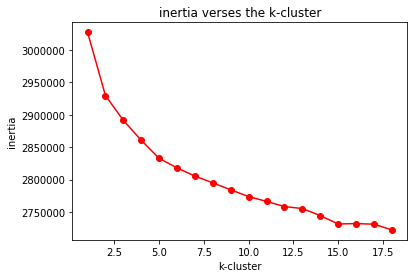

In [60]:
inertia_curve(list=list_kmeans_bow)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [55]:
k,values,feature_names,clf=wordcloud_of_cluster(vect=count_vect,k=5,X=train_bow)

****CLUSTER 1****

CLUSTER ====>>>  1
----------------------
['tea', 'not', 'green', 'like', 'teas', 'taste', 'flavor', 'good', 'one', 'would', 'drink', 'black', 'cup', 'bags', 'no', 'bag', 'get', 'box', 'also', 'love', 'great', 'much', 'water', 'tried', 'really', 'product', 'even', 'find', 'use', 'organic', 'drinking', 'make', 'well', 'leaves', 'time', 'amazon', 'first', 'better', 'little', 'strong']
<function show at 0x000001FBB0D0F048>
******************************


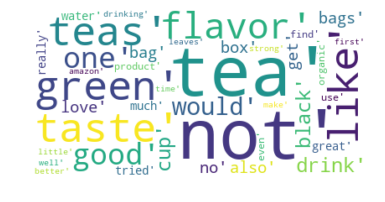

In [56]:
wordcloud(0,k,values=values,feature_names=feature_names)


****CLUSTER 2****

CLUSTER ====>>>  2
----------------------
['not', 'like', 'taste', 'would', 'one', 'product', 'good', 'flavor', 'no', 'get', 'really', 'even', 'amazon', 'much', 'great', 'buy', 'tried', 'time', 'could', 'love', 'also', 'chocolate', 'eat', 'little', 'use', 'try', 'make', 'better', 'first', 'sugar', 'find', 'food', 'well', 'box', 'bought', 'made', 'sweet', 'know', 'think', 'used']
<function show at 0x000001FBB0D0F048>
******************************


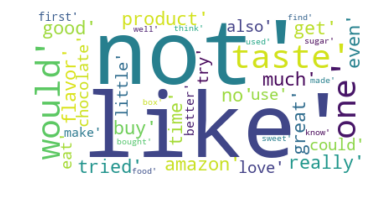

In [57]:
wordcloud(1,k,values=values,feature_names=feature_names)

****CLUSTER 3****

CLUSTER ====>>>  3
----------------------
['food', 'not', 'cat', 'dog', 'cats', 'would', 'one', 'like', 'eat', 'no', 'dogs', 'dry', 'chicken', 'foods', 'good', 'product', 'also', 'ingredients', 'much', 'even', 'get', 'time', 'diet', 'pet', 'quality', 'bag', 'products', 'vet', 'old', 'little', 'well', 'feeding', 'really', 'first', 'feed', 'canned', 'healthy', 'two', 'tried', 'better']
<function show at 0x000001FBB0D0F048>
******************************


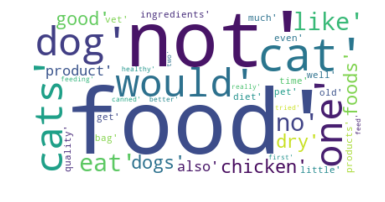

In [58]:
wordcloud(2,k,values=values,feature_names=feature_names)

****CLUSTER 4****

CLUSTER ====>>>  4
----------------------
['not', 'like', 'would', 'taste', 'one', 'product', 'good', 'no', 'flavor', 'get', 'even', 'really', 'sugar', 'much', 'also', 'chocolate', 'could', 'first', 'water', 'well', 'time', 'make', 'eat', 'use', 'little', 'amazon', 'know', 'food', 'try', 'tried', 'better', 'great', 'think', 'buy', 'find', 'made', 'milk', 'something', 'used', 'two']
<function show at 0x000001FBB0D0F048>
******************************


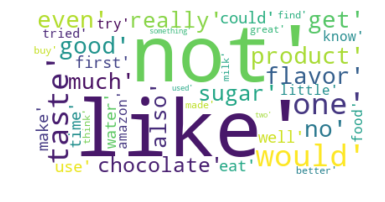

In [59]:
wordcloud(3,k,values=values,feature_names=feature_names)

****CLUSTER 5****

CLUSTER ====>>>  6
----------------------
['coffee', 'not', 'like', 'cup', 'taste', 'flavor', 'good', 'one', 'would', 'roast', 'no', 'beans', 'vanilla', 'get', 'tried', 'cups', 'drink', 'great', 'use', 'flavored', 'strong', 'starbucks', 'even', 'make', 'much', 'really', 'product', 'bitter', 'dark', 'coffees', 'amazon', 'instant', 'blend', 'buy', 'try', 'love', 'better', 'best', 'first', 'bag']
<function show at 0x000001FBB0D0F048>
******************************


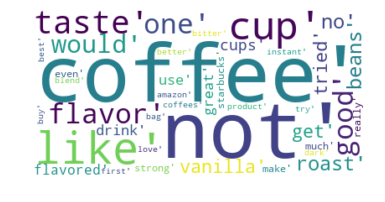

In [61]:
wordcloud(5,k,values=values,feature_names=feature_names)

****CONCLUSION****

1. In ****cluster-1**** we can observe that the cluster is all about ****tea products**** associated with tea bag,its flavor and      drinking behavior of different types of tea like green,black 

2. The ****cluster 2**** is about the sweet chocholate flavor  box 

3. This ****cluster-3**** is about pet cats or dogs food like chicken,etc

4. This ****cluster-4**** is representing sugary product like chocholate

5. This ****cluster-5**** is representing products related to cold coffee products,cup,valina flavour

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [106]:
# Please write all the code with proper documentation
list_kmeans_tfidf,clf=kMeans(x_train=train_tf_idf)



For no of cluster  1  the inertia is  47405.48533859387
For no of cluster  3  the inertia is  46156.12138043449
For no of cluster  5  the inertia is  45564.469836109536
For no of cluster  7  the inertia is  45099.268815183015
For no of cluster  9  the inertia is  44759.43257896944
For no of cluster  11  the inertia is  44385.55006408369
For no of cluster  13  the inertia is  44134.34925707161
For no of cluster  15  the inertia is  43864.03561400404
For no of cluster  17  the inertia is  43638.58152567249
[47405.48533859387, 46156.12138043449, 45564.469836109536, 45099.268815183015, 44759.43257896944, 44385.55006408369, 44134.34925707161, 43864.03561400404, 43638.58152567249]


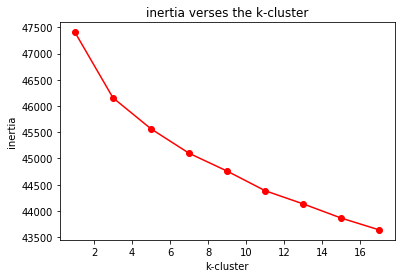

In [107]:
inertia_curve(list=list_kmeans_tfidf)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

****CLUSTER 1****


CLUSTER ====>>>  2
----------------------
['dog', 'food', 'treats', 'cat', 'dogs', 'not', 'cats', 'treat', 'eat', 'loves', 'would', 'one', 'dog food', 'like', 'chicken', 'love', 'cat food', 'vet', 'product', 'get', 'good', 'even', 'pet', 'give', 'toy', 'dry', 'small', 'no', 'feed', 'much', 'time', 'two', 'bag', 'dog loves', 'old', 'great', 'ingredients', 'little', 'dogs love', 'also']
<function show at 0x000001FBB0D0F048>
******************************


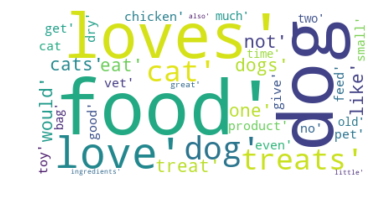

In [65]:
k,values,feature_names,clf=wordcloud_of_cluster(vect=tf_idf_vect,k=7,X=train_tf_idf)

wordcloud(1,k,values=values,feature_names=feature_names)


****CLUSTER 2****

CLUSTER ====>>>  1
----------------------
['gluten', 'gluten free', 'free', 'bread', 'not', 'mix', 'flour', 'wheat', 'cookies', 'good', 'taste', 'pasta', 'like', 'great', 'make', 'products', 'gf', 'cake', 'best', 'tried', 'eat', 'celiac', 'product', 'texture', 'free diet', 'one', 'pamela', 'even', 'not gluten', 'made', 'diet', 'rice', 'love', 'would', 'chocolate', 'best gluten', 'really', 'free products', 'also', 'found']
<function show at 0x000001FBB0D0F048>
******************************


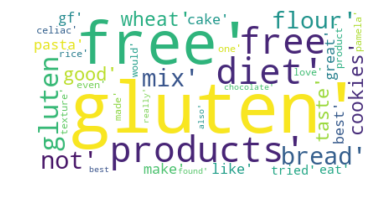

In [66]:
wordcloud(0,k,values=values,feature_names=feature_names)

****CLUSTER 4****

CLUSTER ====>>>  4
----------------------
['coffee', 'cup', 'not', 'like', 'flavor', 'taste', 'roast', 'cups', 'good', 'coffee not', 'strong', 'cup coffee', 'one', 'great', 'beans', 'would', 'bold', 'pods', 'starbucks', 'bitter', 'blend', 'instant', 'flavored', 'coffees', 'dark', 'love', 'drink', 'vanilla', 'decaf', 'tried', 'instant coffee', 'espresso', 'best', 'keurig', 'no', 'price', 'weak', 'tastes', 'smooth', 'buy']
<function show at 0x000001FBB0D0F048>
******************************


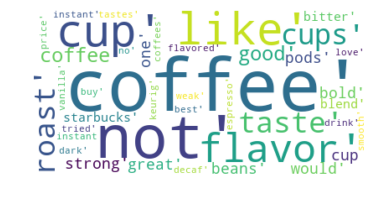

In [68]:
wordcloud(3,k,values=values,feature_names=feature_names)


****CLUSTER 5****

CLUSTER ====>>>  5
----------------------
['tea', 'green', 'green tea', 'not', 'teas', 'like', 'flavor', 'taste', 'good', 'drink', 'tea not', 'bags', 'love', 'black', 'one', 'great', 'cup', 'iced', 'black tea', 'tea bags', 'chai', 'iced tea', 'grey', 'drinking', 'love tea', 'tried', 'strong', 'earl', 'would', 'bag', 'loose', 'earl grey', 'really', 'no', 'box', 'tastes', 'hot', 'find', 'leaves', 'best']
<function show at 0x000001FBB0D0F048>
******************************


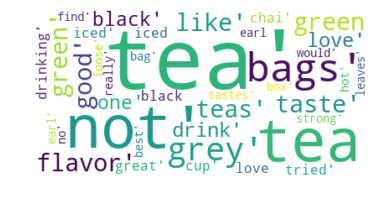

In [70]:
wordcloud(4,k,values=values,feature_names=feature_names)

****CLUSTER 6****

CLUSTER ====>>>  6
----------------------
['product', 'amazon', 'not', 'price', 'order', 'store', 'shipping', 'buy', 'box', 'find', 'would', 'ordered', 'great', 'item', 'received', 'grocery', 'local', 'get', 'good', 'time', 'one', 'stores', 'no', 'arrived', 'love', 'could', 'grocery store', 'bought', 'cans', 'much', 'purchase', 'found', 'like', 'never', 'boxes', 'purchased', 'service', 'got', 'date', 'company']
<function show at 0x000001FBB0D0F048>
******************************


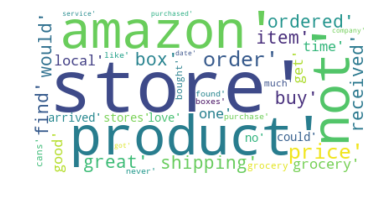

In [71]:
wordcloud(5,k,values=values,feature_names=feature_names)


****CLUSTER 7****

CLUSTER ====>>>  7
----------------------
['not', 'like', 'taste', 'chocolate', 'good', 'would', 'flavor', 'sugar', 'sweet', 'really', 'one', 'tastes', 'product', 'no', 'much', 'taste like', 'bars', 'cookies', 'even', 'not like', 'bad', 'not taste', 'tried', 'drink', 'eat', 'bar', 'love', 'better', 'try', 'great', 'get', 'could', 'water', 'buy', 'milk', 'tasted', 'juice', 'little', 'think', 'texture']
<function show at 0x000001FBB0D0F048>
******************************


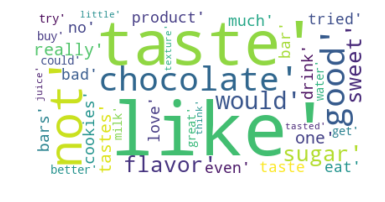

In [72]:
wordcloud(6,k,values=values,feature_names=feature_names)


****CONCLUSION****

1. In ****cluster-1**** is about pet cats or dogs food like chicken,etc
2. In ****cluster-2**** is all about grossary product like bread,cookies,wheat,flour,etc
3. In ****cluster-3**** is representing products related to cold coffee products,cup,valina flavouR
4. In  ****cluster-4**** we can observe that the cluster is all about ****tea products**** associated with tea bag,its flavor and drinking behavior of different types of tea like green,black 
5. In ****cluster-5**** represents the process of selling and buying from store including price,grocery
6. In ****cluster-6**** shows ****chocholate**** flavor product like cookies and the product used to make chocholate

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

For no of cluster  1  the inertia is  366633.8515184731
For no of cluster  3  the inertia is  300939.92414670583
For no of cluster  5  the inertia is  273719.0386320761
For no of cluster  7  the inertia is  258524.99478433674
For no of cluster  9  the inertia is  245835.56848675053
For no of cluster  11  the inertia is  236979.3458643728
For no of cluster  13  the inertia is  231276.22958018194
For no of cluster  15  the inertia is  226342.48479438692
For no of cluster  17  the inertia is  222242.33603137376
[366633.8515184731, 300939.92414670583, 273719.0386320761, 258524.99478433674, 245835.56848675053, 236979.3458643728, 231276.22958018194, 226342.48479438692, 222242.33603137376]


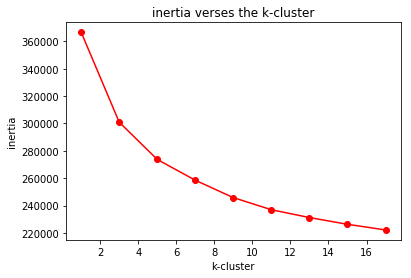

In [90]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
list_kmeans_avgw2v,clf=kMeans(x_train=sent_vectors_train)
inertia_curve(list=list_kmeans_avgw2v)


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [28]:
clf=KMeans(n_clusters=7).fit(sent_vectors_train)
   


In [29]:
# Getting all the reviews in different clusters
#below function taken from https://github.com/PushpendraSinghChauhan/Amazon-Fine-FoodReviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb
reviews =x_train
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif clf.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif clf.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif clf.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif clf.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif clf.labels_[i] == 5:
        cluster6.append(reviews[i])
            
    else:
        cluster7.append(reviews[i])
   
   
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))


No. of reviews in Cluster-1 :  3270

No. of reviews in Cluster-2 :  9682

No. of reviews in Cluster-3 :  3950

No. of reviews in Cluster-4 :  11201

No. of reviews in Cluster-5 :  4934

No. of reviews in Cluster-6 :  5593

No. of reviews in Cluster-7 :  11370


<function show at 0x00000153B053E048>
******************************


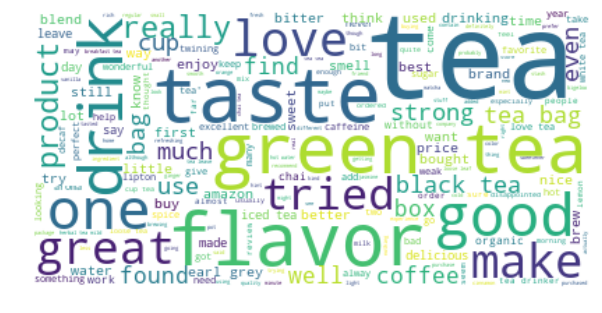

In [30]:
wordcloud=WordCloud(background_color="white").generate(str(cluster1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


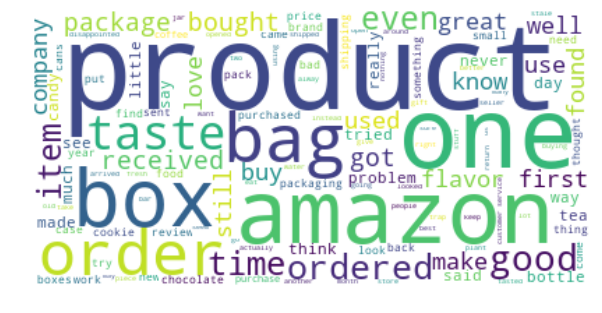

In [31]:
wordcloud=WordCloud(background_color="white").generate(str(cluster2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


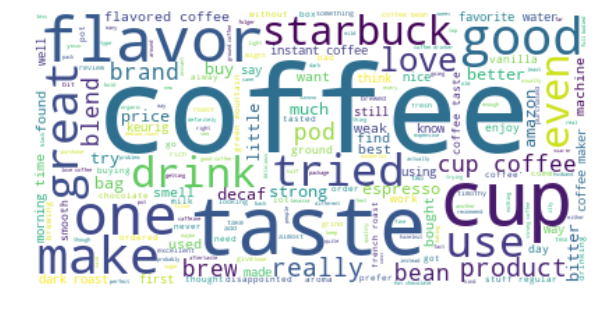

In [34]:
wordcloud=WordCloud(background_color="white").generate(str(cluster3))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


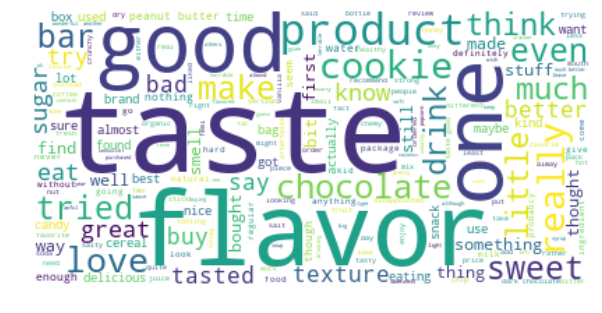

In [33]:
wordcloud=WordCloud(background_color="white").generate(str(cluster4))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


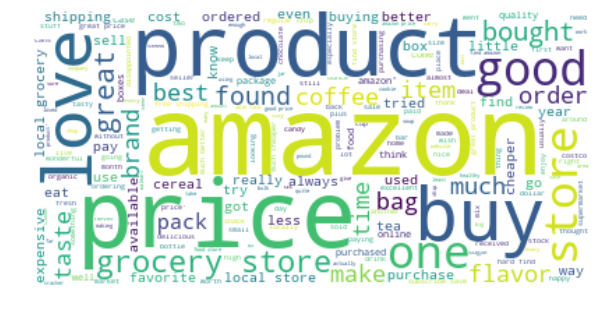

In [35]:
wordcloud=WordCloud(background_color="white").generate(str(cluster5))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


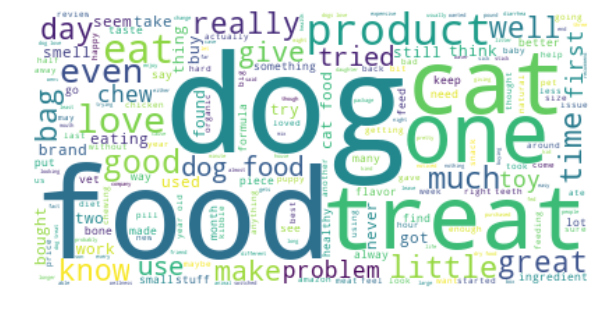

In [36]:
wordcloud=WordCloud(background_color="white").generate(str(cluster6))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


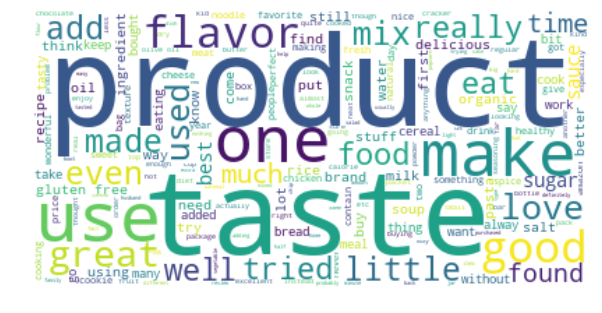

In [37]:
wordcloud=WordCloud(background_color="white").generate(str(cluster7))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

****CONCLUSION****

1. In  ****cluster-4**** we can observe that the cluster is all about ****tea products**** associated with tea bag,its flavor and drinking behavior of different types of tea like green,black 
5. In ****cluster-5**** represents the process of selling and buying from store including price,grocery

3. In ****cluster-3**** is representing products related to cold coffee products,cup,valina flavouR
6. In ****cluster-6**** shows ****chocholate**** flavor product like cookies and the product used to make chocholate
2. In ****cluster-2**** is all about grossary product like bread,cookies,wheat,flour,etc

1. In ****cluster-1**** is about pet cats or dogs food like chicken,etc

2. In ****cluster-2**** is all about grossary product like bread,cookies,wheat,flour,etc


### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

For no of cluster  1  the inertia is  502423.8155493542
For no of cluster  3  the inertia is  405429.3462581212
For no of cluster  5  the inertia is  366979.9919103531
For no of cluster  7  the inertia is  339436.08827260096
For no of cluster  9  the inertia is  320654.0325338791
For no of cluster  11  the inertia is  307339.36904607504
For no of cluster  13  the inertia is  297350.3790892118
For no of cluster  15  the inertia is  289590.2593409561
For no of cluster  17  the inertia is  282955.40148866124
[502423.8155493542, 405429.3462581212, 366979.9919103531, 339436.08827260096, 320654.0325338791, 307339.36904607504, 297350.3790892118, 289590.2593409561, 282955.40148866124]


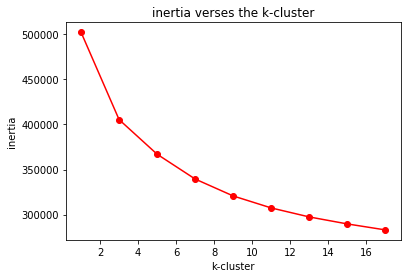

In [96]:
# Please write all the code with proper documentation
list_kmeans_tfidfw2v,clf=kMeans(x_train=tfidf_sent_vectors_train) 

inertia_curve(list=list_kmeans_tfidfw2v)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [44]:
# Please write all the code with proper documentation
clf=KMeans(n_clusters=5).fit(tfidf_sent_vectors_train)
    

In [46]:
# Getting all the reviews in different clusters
#below function taken from https://github.com/PushpendraSinghChauhan/Amazon-Fine-FoodReviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb
reviews =x_train
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
for i in range(clf.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif clf.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif clf.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif clf.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif clf.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif clf.labels_[i] == 5:
        cluster6.append(reviews[i])
            
    else:
        cluster7.append(reviews[i])
   
   
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))


No. of reviews in Cluster-1 :  9835

No. of reviews in Cluster-2 :  14600

No. of reviews in Cluster-3 :  5169

No. of reviews in Cluster-4 :  6278

No. of reviews in Cluster-5 :  14118


<function show at 0x00000153B053E048>
******************************


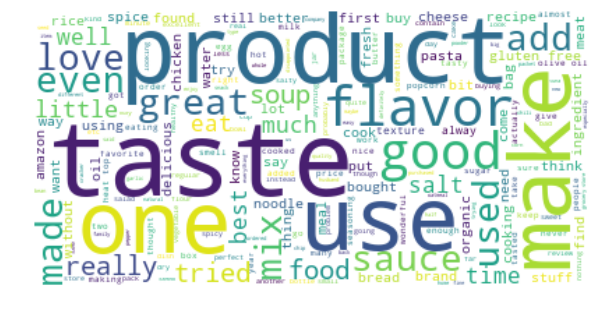

In [47]:
wordcloud=WordCloud(background_color="white").generate(str(cluster1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


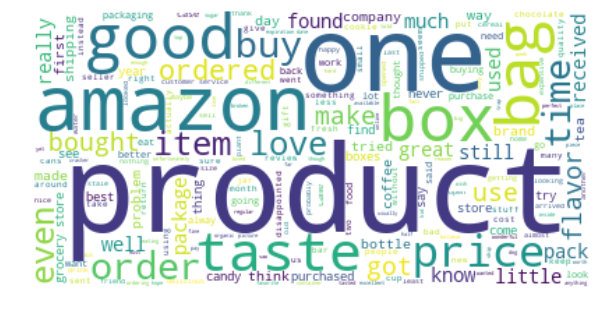

In [48]:
wordcloud=WordCloud(background_color="white").generate(str(cluster2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


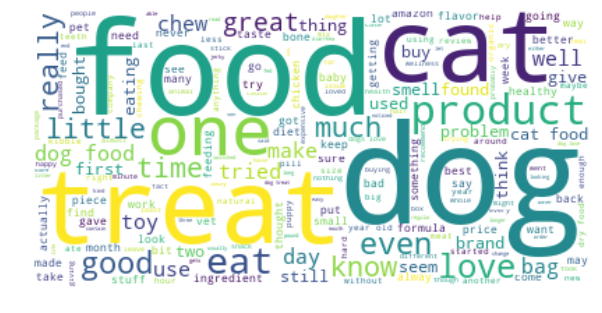

In [49]:
wordcloud=WordCloud(background_color="white").generate(str(cluster3))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


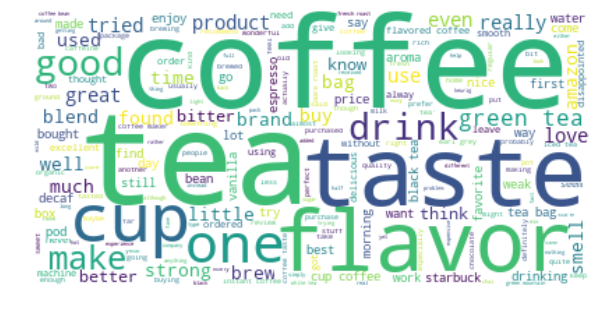

In [50]:
wordcloud=WordCloud(background_color="white").generate(str(cluster4))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x00000153B053E048>
******************************


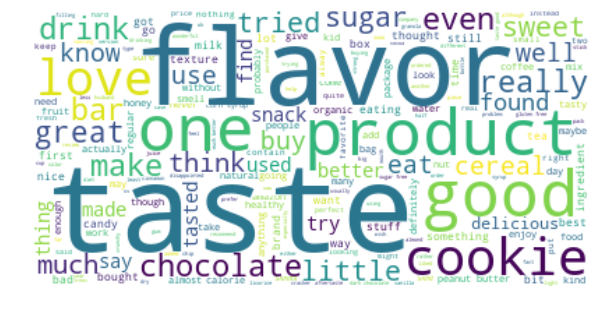

In [51]:
wordcloud=WordCloud(background_color="white").generate(str(cluster5))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

****CONCLUSION****


1. In ****cluster-1**** is all about grossary product like bread,cookies,wheat,flour,etc
2. In ****cluster-2**** represents the process of selling and buying from store including price,grocery
3. In ****cluster-3**** is about pet cats or dogs food like chicken,etc
4. In ****cluster-4**** is representing products related to cold coffee products,cup,valina flavouR
5. In ****cluster-5**** shows ****chocholate**** flavor product like cookies and the product used to make chocholate


## [5.2] Agglomerative Clustering

In [8]:
from sklearn.cluster import AgglomerativeClustering

In [9]:
agg_2=AgglomerativeClustering(n_clusters=2, affinity="euclidean", memory=None, connectivity=None,
compute_full_tree="auto", linkage="ward", pooling_func="deprecated")
agg_2.fit(sent_vectors_train)


agg_5=AgglomerativeClustering(n_clusters=5, affinity="euclidean", memory=None, connectivity=None,
compute_full_tree="auto", linkage="ward", pooling_func="deprecated")
agg_5.fit(sent_vectors_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [10]:

pred_2=agg_2.fit_predict(sent_vectors_train)
pred_5=agg_5.fit_predict(sent_vectors_train)

In [12]:
# Please write all the code with proper documentation
reviews=x_train
index_1=[]
index_2=[]
for i in range(len(pred_2)):
    if pred_2[i]==0:
        index_1.append((reviews[i]))
    if pred_2[i]==1:
        index_2.append((reviews[i]))
        

print("WHEN CLUSTER NO IS 2")
print("")
print("Points that have 0 as predicted values =",len(index_1))
print("Points that have 1 as predicted values =",len(index_2))

print("")
print("*****************************************************")

WHEN CLUSTER NO IS 2

Points that have 0 as predicted values = 1636
Points that have 1 as predicted values = 3364

*****************************************************



### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

CLUSTER NUMBER=2

<function show at 0x000001696291E048>
******************************


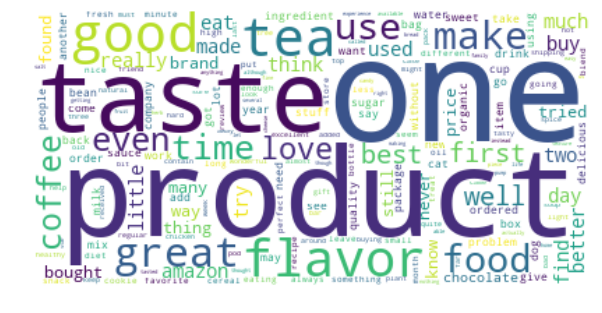

In [15]:
wordcloud=WordCloud(background_color="white").generate(str(index_1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


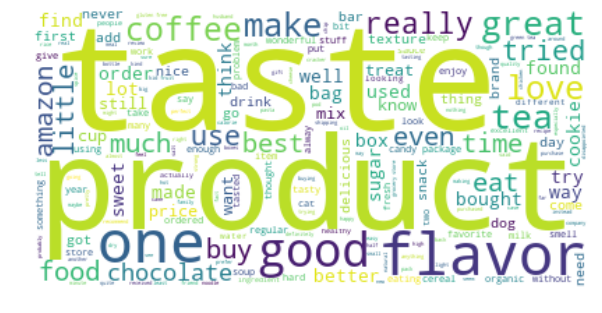

In [16]:
wordcloud=WordCloud(background_color="white").generate(str(index_2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

****CONCLUSION****

Could not be differenciated with cluster 2

CLUSTER NUMBER=5

In [17]:
index_1=[]
index_2=[]
index_3=[]
index_4=[]
index_5=[]

for i in range(len(pred_5)):
    if pred_5[i]==0:
        index_1.append(reviews[i])
    if pred_5[i]==1:
        index_2.append(reviews[i])
    if pred_5[i]==2:
        index_3.append(reviews[i])
    if pred_5[i]==3:
        index_4.append(reviews[i])
    if pred_5[i]==4:
        index_5.append(reviews[i])

print("WHEN CLUSTER NO IS 5")
print("")
print("Points that have 0 as predicted values =",len(index_1))
print("Points that have 1 as predicted values =",len(index_2))
print("Points that have 2 as predicted values =",len(index_3))
print("Points that have 3 as predicted values =",len(index_4))
print("Points that have 4 as predicted values =",len(index_5))

WHEN CLUSTER NO IS 5

Points that have 0 as predicted values = 1617
Points that have 1 as predicted values = 1947
Points that have 2 as predicted values = 19
Points that have 3 as predicted values = 914
Points that have 4 as predicted values = 503


<function show at 0x000001696291E048>
******************************


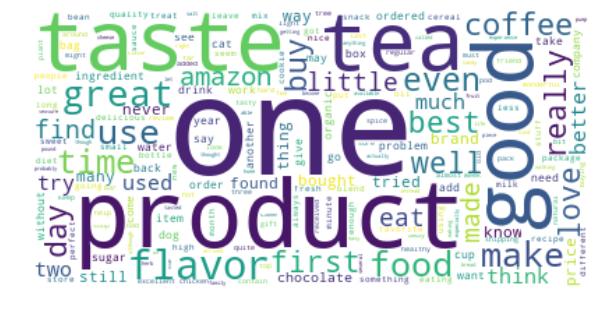

In [18]:
wordcloud=WordCloud(background_color="white").generate(str(index_1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


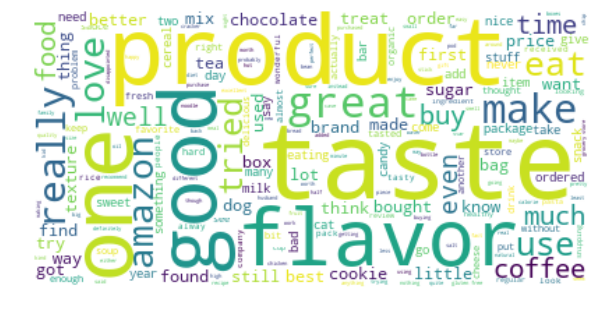

In [19]:
wordcloud=WordCloud(background_color="white").generate(str(index_2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


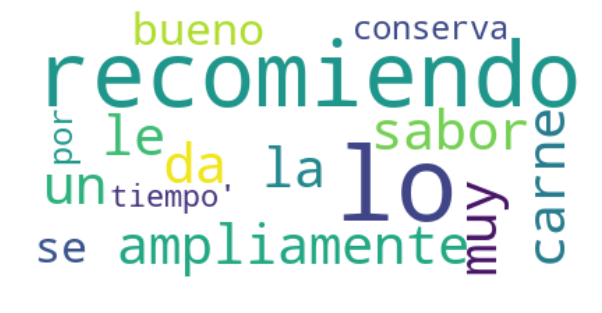

In [20]:
wordcloud=WordCloud(background_color="white").generate(str(index_3))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


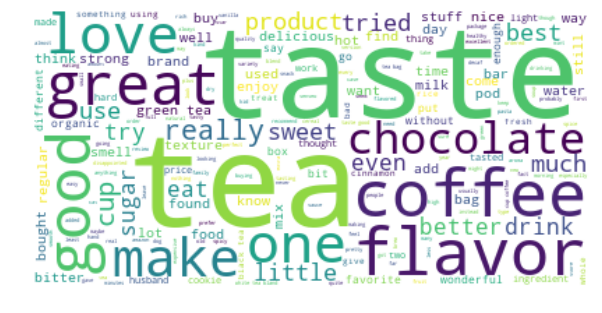

In [21]:
wordcloud=WordCloud(background_color="white").generate(str(index_4))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


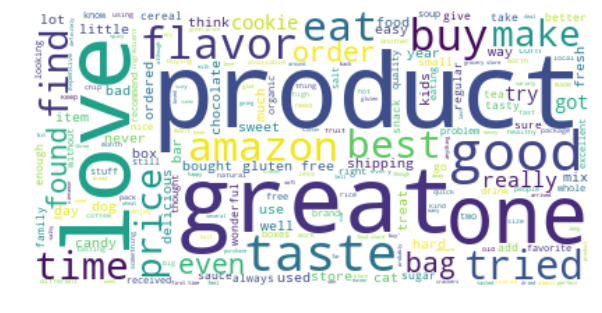

In [22]:
wordcloud=WordCloud(background_color="white").generate(str(index_5))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

****CONCLUSION****

Most of the words are present in all the clusters  so could be differeciated accuarately but in cluster-3 the words present have o meaig at all

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
# Please write all the code with proper documentation
agg_2=AgglomerativeClustering(n_clusters=2, affinity="euclidean", memory=None, connectivity=None,
compute_full_tree="auto", linkage="ward", pooling_func="deprecated")
agg_2.fit(tfidf_sent_vectors_train)


agg_5=AgglomerativeClustering(n_clusters=5, affinity="euclidean", memory=None, connectivity=None,
compute_full_tree="auto", linkage="ward", pooling_func="deprecated")
agg_5.fit(tfidf_sent_vectors_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [93]:
pred_2=agg_2.fit_predict(tfidf_sent_vectors_train)
pred_5=agg_5.fit_predict(tfidf_sent_vectors_train)

In [26]:
# Please write all the code with proper documentation
reviews=x_train
index_1=[]
index_2=[]
for i in range(len(pred_2)):
    if pred_2[i]==0:
        index_1.append((reviews[i]))
    if pred_2[i]==1:
        index_2.append((reviews[i]))
        

print("WHEN CLUSTER NO IS 2")
print("")
print("Points that have 0 as predicted values =",len(index_1))
print("Points that have 1 as predicted values =",len(index_2))

print("")
print("*****************************************************")

WHEN CLUSTER NO IS 2

Points that have 0 as predicted values = 2590
Points that have 1 as predicted values = 2410

*****************************************************


****CLUSTER 2****

<function show at 0x000001696291E048>
******************************


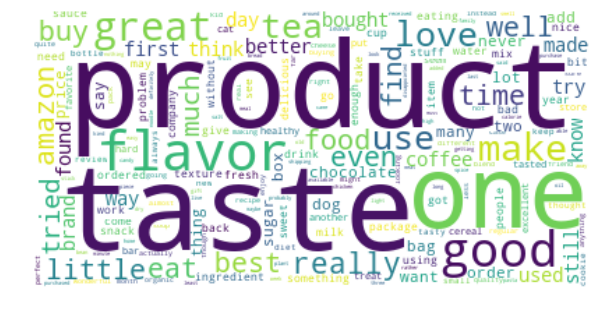

In [27]:
wordcloud=WordCloud(background_color="white").generate(str(index_1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

****CONCLUSION**** The cluster contains grocery items

<function show at 0x000001696291E048>
******************************


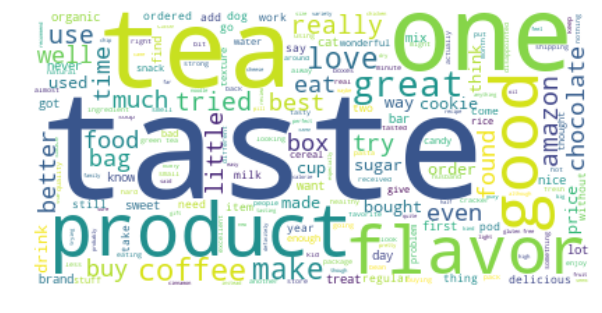

In [28]:
wordcloud=WordCloud(background_color="white").generate(str(index_2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

****CONCLUSION**** This cluster contains tea,chocolate,coffee,bakery,etc hece food items

In [94]:
index_1=[]
index_2=[]
index_3=[]
index_4=[]
index_5=[]

for i in range(len(pred_5)):
    if pred_5[i]==0:
        index_1.append(reviews[i])
    if pred_5[i]==1:
        index_2.append(reviews[i])
    if pred_5[i]==2:
        index_3.append(reviews[i])
    if pred_5[i]==3:
        index_4.append(reviews[i])
    if pred_5[i]==4:
        index_5.append(reviews[i])

print("WHEN CLUSTER NO IS 5")
print("")
print("Points that have 0 as predicted values =",len(index_1))
print("Points that have 1 as predicted values =",len(index_2))
print("Points that have 2 as predicted values =",len(index_3))
print("Points that have 3 as predicted values =",len(index_4))
print("Points that have 4 as predicted values =",len(index_5))

WHEN CLUSTER NO IS 5

Points that have 0 as predicted values = 1315
Points that have 1 as predicted values = 921
Points that have 2 as predicted values = 1651
Points that have 3 as predicted values = 18
Points that have 4 as predicted values = 1095


**** CLUSTER 5****

<function show at 0x000001696291E048>
******************************


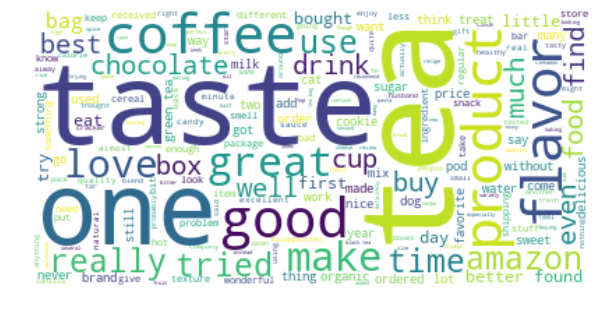

In [30]:
wordcloud=WordCloud(background_color="white").generate(str(index_1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


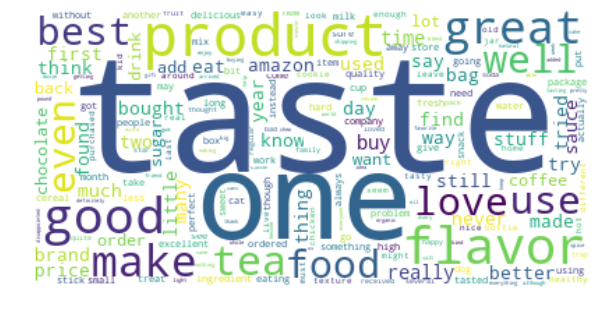

In [95]:
wordcloud=WordCloud(background_color="white").generate(str(index_2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


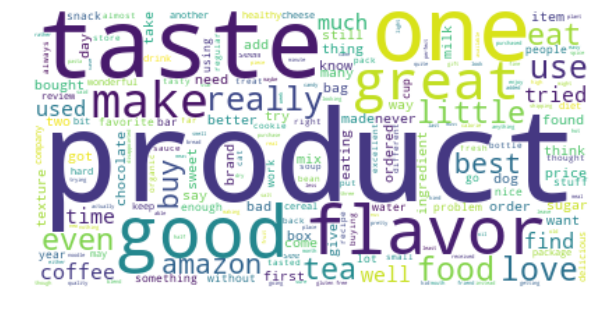

In [32]:
wordcloud=WordCloud(background_color="white").generate(str(index_3))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

<function show at 0x000001696291E048>
******************************


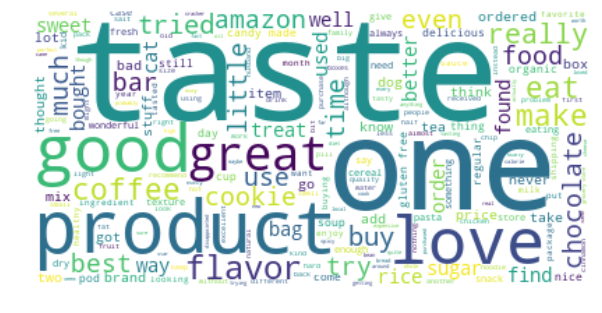

In [35]:
wordcloud=WordCloud(background_color="white").generate(str(index_5))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

## [5.3] DBSCAN Clustering

**** Ideally we take min_points which is double the dimension of the dimention  of data ****

In [10]:
min_points=2*len((sent_vectors_train)[1])
min_points

100

****Using NearesrNeighbours to calculate the DISTANCE and INDEXCES****

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [60]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(n_neighbors=min_points)
knn.fit(sent_vectors_train)
distance,index=knn.kneighbors(sent_vectors_train)
print("Shape of index",index.shape)
print("Shape of distance",distance.shape)

Shape of index (5000, 100)
Shape of distance (5000, 100)


In [61]:
#sorting the distance in the reverse order
sorted_distance=sorted(distance[:,-1])
sorted_distance[:10]

[0.05657896276660497,
 0.05686640264650686,
 0.057217999225198546,
 0.05737952762862351,
 0.05753966352430216,
 0.05774767945607713,
 0.05804048283975761,
 0.058101755476502065,
 0.05816401330713127,
 0.0583235296926011]

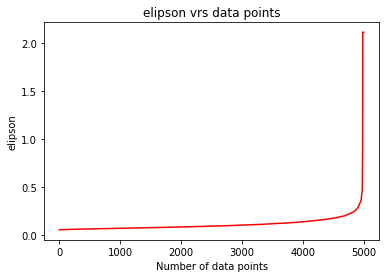

In [62]:
list=np.arange(1,5001)
plt.plot(list,sorted_distance,'r-')
plt.title('elipson vrs data points')
plt.ylabel('elipson')
plt.xlabel('Number of data points')
    
plt.show()

****Considering the epsilon value as 1.5****

In [64]:
from sklearn.cluster import DBSCAN
#initializing the classifier
clf=DBSCAN(eps=0.4, min_samples=min_points, metric="euclidean", metric_params=None, algorithm="auto", leaf_size=30,n_jobs=-1)
pred=clf.fit_predict(sent_vectors_train)

In [65]:
len(pred)

5000

In [66]:
# Please write all the code with proper documentation
reviews=x_train
index_1=[]
index_2=[]
for i in range(len(pred)):
    if pred[i]==0:
        index_1.append((reviews[i]))
    else:
        index_2.append((reviews[i]))
        

print("WHEN CLUSTER NO IS 2")
print("")
print("Points that have 0 as predicted values =",len(index_1))
print("Points that have 1 as predicted values =",len(index_2))

print("")
print("*****************************************************")

WHEN CLUSTER NO IS 2

Points that have 0 as predicted values = 4980
Points that have 1 as predicted values = 20

*****************************************************


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

<function show at 0x00000153B053E048>
******************************


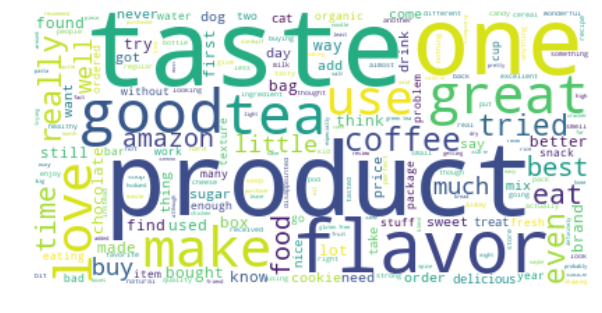

In [67]:
wordcloud=WordCloud(background_color="white").generate(str(index_1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

This cluster only contain meaningful words

<function show at 0x00000153B053E048>
******************************


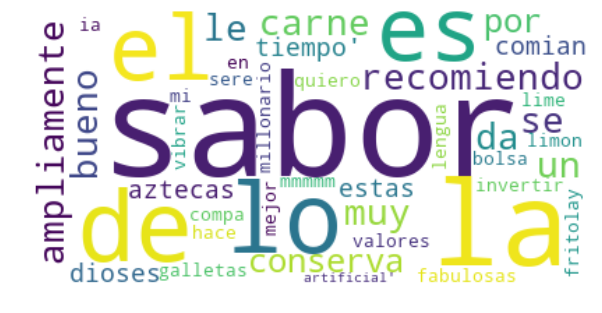

In [68]:
wordcloud=WordCloud(background_color="white").generate(str(index_2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

This works really amazing in removing the noise from the review 

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [11]:
# Please write all the code with proper documentation
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(n_neighbors=min_points)
knn.fit(tfidf_sent_vectors_train)
distance,index=knn.kneighbors(tfidf_sent_vectors_train)
print("Shape of index",index.shape)
print("Shape of distance",distance.shape)

Shape of index (5000, 100)
Shape of distance (5000, 100)


In [12]:
sort=sorted(distance[:,-1])
sort[:10]

[0.05504267547967328,
 0.05606420188255031,
 0.05653606917595262,
 0.05682501036201756,
 0.05702394365453103,
 0.057455325328203265,
 0.05752752690720819,
 0.05757877209049152,
 0.05758161384023442,
 0.05777231058099511]

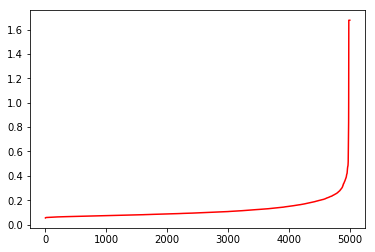

In [13]:
list=np.arange(1,5001)
plt.plot(list,sort,'r-')
plt.show()

In [14]:
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=.4, min_samples=min_points, metric="euclidean", metric_params=None, algorithm="auto", leaf_size=30, p=None, n_jobs=-1)
pred=db.fit_predict(tfidf_sent_vectors_train)
print("lenght of the predicted values",len(pred))

lenght of the predicted values 5000


In [15]:
# Please write all the code with proper documentation
reviews=x_train
index_1=[]
index_2=[]
for i in range(len(pred)):
    if pred[i]==0:
        index_1.append((reviews[i]))
    else:
        index_2.append((reviews[i]))
        

print("WHEN CLUSTER NO IS 2")
print("")
print("Points that have 0 as predicted values =",len(index_1))
print("Points that have 1 as predicted values =",len(index_2))

print("")
print("*****************************************************")

WHEN CLUSTER NO IS 2

Points that have 0 as predicted values = 4979
Points that have 1 as predicted values = 21

*****************************************************


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

<function show at 0x000001F811D9D840>
******************************


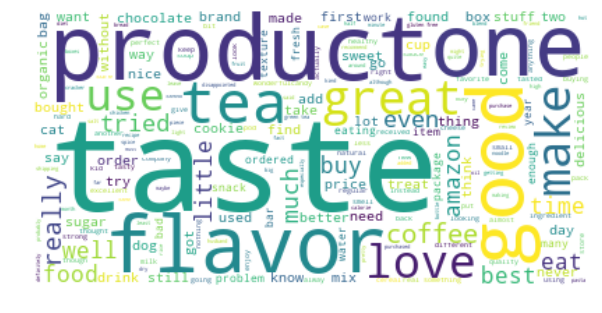

In [20]:
wordcloud=WordCloud(background_color="white").generate(str(index_1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

This cluster contains only meaningful words

<function show at 0x000001F811D9D840>
******************************


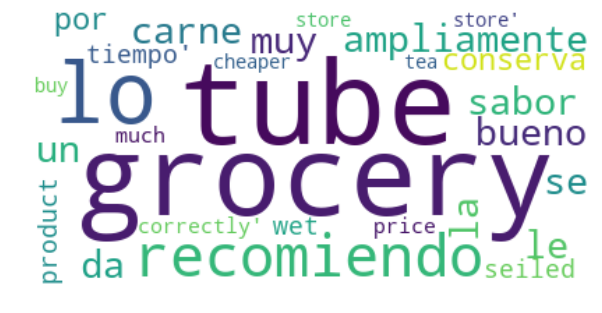

In [19]:
wordcloud=WordCloud(background_color="white").generate(str(index_2))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
 

In this method of clustering we can remove the noise from the review 

# [6] Conclusions

In [27]:
#Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()
print("COMPARISION OF THE K-MEANS MODELS WITH DIFFERENT NUMBER OF CLUSTER")
x.field_names = ["Vectorizer","model" ,"inertia","no_of_clusters"]

x.add_row(["BOW", " k-means",2832678.418255732,5])
x.add_row(["TF-IDF"," k-means",45099.268815183015,7])
x.add_row(["AVG-W2V"," k-means",258524.99478433674,7])
x.add_row(["TF-IDF-W2V"," k-means",366979.9919103531,5])


print(x)


COMPARISION OF THE K-MEANS MODELS WITH DIFFERENT NUMBER OF CLUSTER
+------------+----------+--------------------+----------------+
| Vectorizer |  model   |      inertia       | no_of_clusters |
+------------+----------+--------------------+----------------+
|    BOW     |  k-means | 2832678.418255732  |       5        |
|   TF-IDF   |  k-means | 45099.268815183015 |       7        |
|  AVG-W2V   |  k-means | 258524.99478433674 |       7        |
| TF-IDF-W2V |  k-means | 366979.9919103531  |       5        |
+------------+----------+--------------------+----------------+


In [33]:
#Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()
print("COMPARISION OF THE MODELS WITH different umber of CLUSTER")
x.field_names = ["Vectorizer","model" ,"no_of_clusters"]


x.add_row(["AVG-W2V"," Agllomerative",'2,4'])
x.add_row(["TF-IDF-W2V"," Agllomerative",'2,4'])


print(x)


COMPARISION OF THE MODELS WITH different umber of CLUSTER
+------------+----------------+----------------+
| Vectorizer |     model      | no_of_clusters |
+------------+----------------+----------------+
|  AVG-W2V   |  Agllomerative |      2,4       |
| TF-IDF-W2V |  Agllomerative |      2,4       |
+------------+----------------+----------------+


In [34]:
#Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()
print("COMPARISION OF THE DBSCAN with epsilon and no of cluster ")
x.field_names = ["Vectorizer","model" ,"epsilon","no_of_clusters"]


x.add_row(["AVG-W2V"," DBSCAN",.4,2])
x.add_row(["TF-IDF-W2V"," DBSCAN",.4,2])


print(x)


COMPARISION OF THE DBSCAN with epsilon and no of cluster 
+------------+---------+---------+----------------+
| Vectorizer |  model  | epsilon | no_of_clusters |
+------------+---------+---------+----------------+
|  AVG-W2V   |  DBSCAN |   0.4   |       2        |
| TF-IDF-W2V |  DBSCAN |   0.4   |       2        |
+------------+---------+---------+----------------+
